In [16]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [17]:
!ls /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1

captions.txt  Images


In [18]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/phase3'

import sys
sys.path.append('/content/drive/MyDrive/phase3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
import time
import numpy as np

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from ph3 import *
import os
import torch.optim as optim
import torch
import pickle


In [21]:
if torch.cuda.is_available:
  print('Good to go!')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


In [22]:
# Configuration
image_size = (128, 128)
data_paht = f"{path}/Images"
captions_path = f"{path}/captions.txt"
data_dict_path = f"{base_dir}/image_captioning_dataset.pt"

data_dict = load_data(data_dict_path, captions_path, data_paht, image_size)

/content/drive/MyDrive/phase3/ph3.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path)


Dataset loaded successfully.


In [23]:
num_train = len(data_dict['train_images'])
num_val = len(data_dict['val_images'])
print(f'num_train: {num_train}')
print(f'num_val: {num_val}')

num_train: 7281
num_val: 810


### function for data augmentation

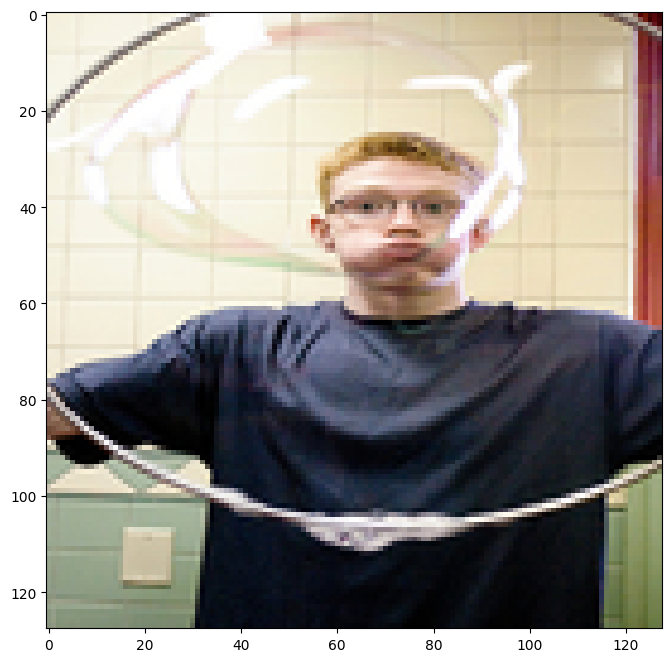

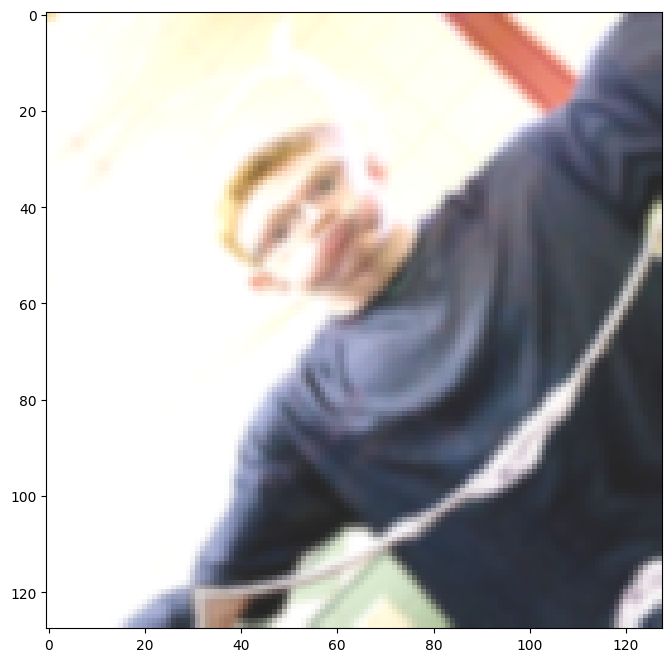

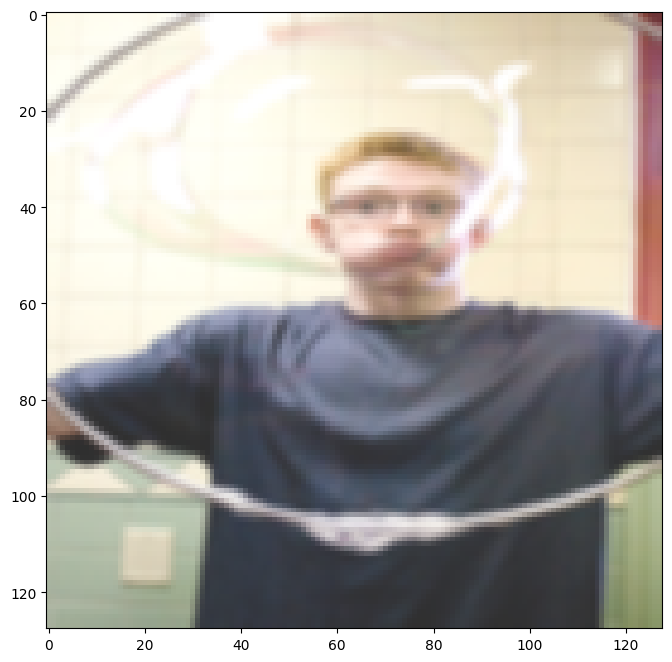

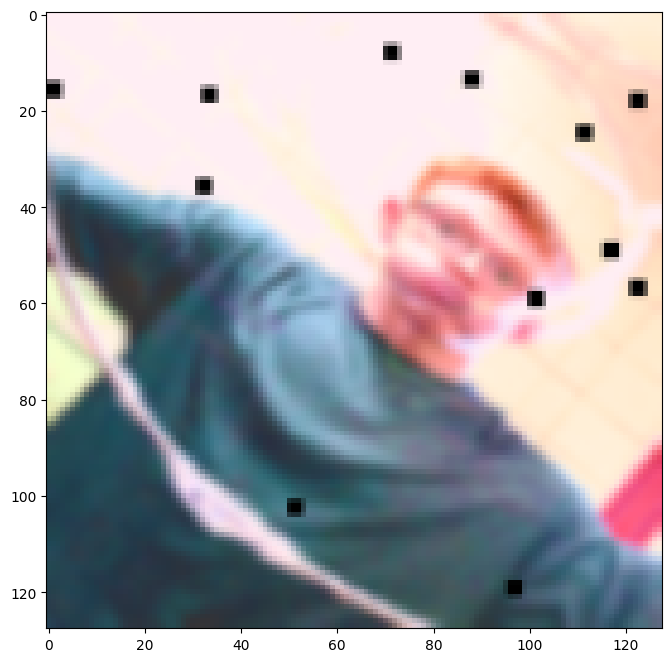

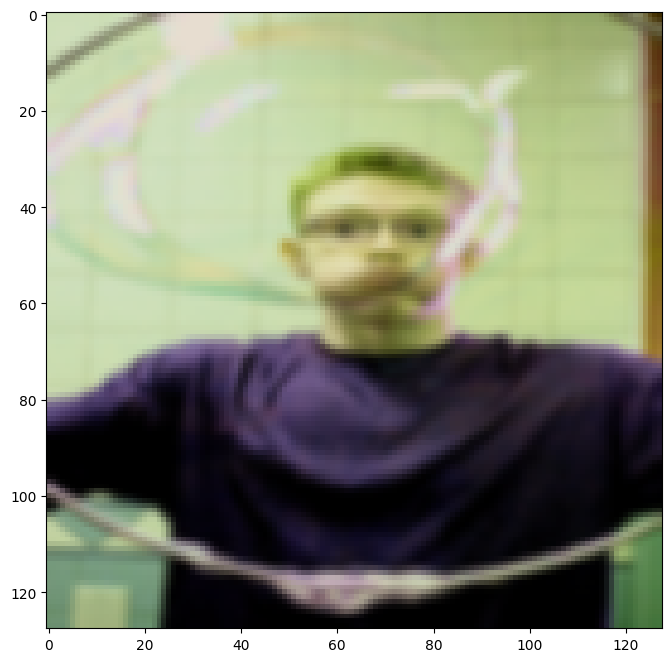

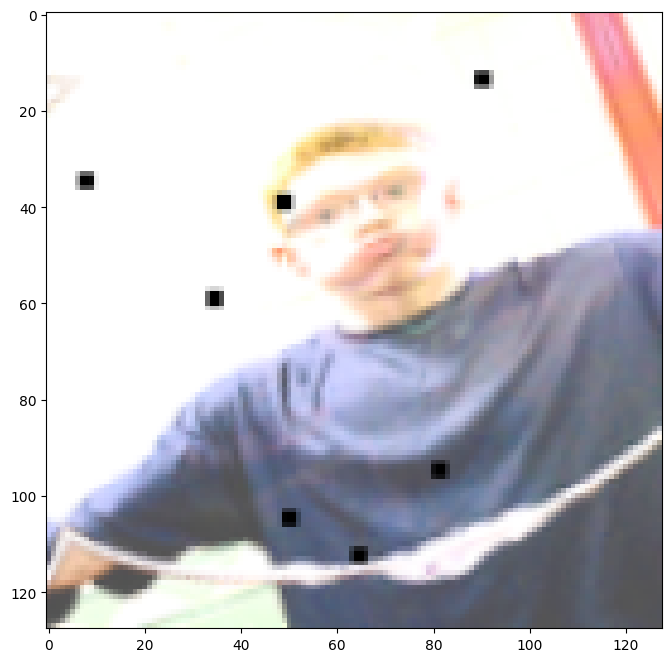

In [24]:
ag_img = process_images(data_dict['train_images'][0], image_size=image_size, augment=True)
for i in range(ag_img.shape[0]):
    img = ag_img[i].permute(1, 2, 0).to(torch.int32)
    plt.imshow(img)
    plt.show()

In [25]:
data_dict['train_captions'].shape

torch.Size([7281, 5, 38])

In [26]:
len(data_dict["vocab"]["idx_to_token"])

8456

We have 6,472 lists of captions.

- Each list contains 5 captions.  
- Each caption consists of 40 tokens (with padding).  
- Each token is represented as a vector of size 8,908 (one-hot encoding).  


In [27]:
PAD_index = 0

`start = 1`,
`end = 2`,
`pad = 0`

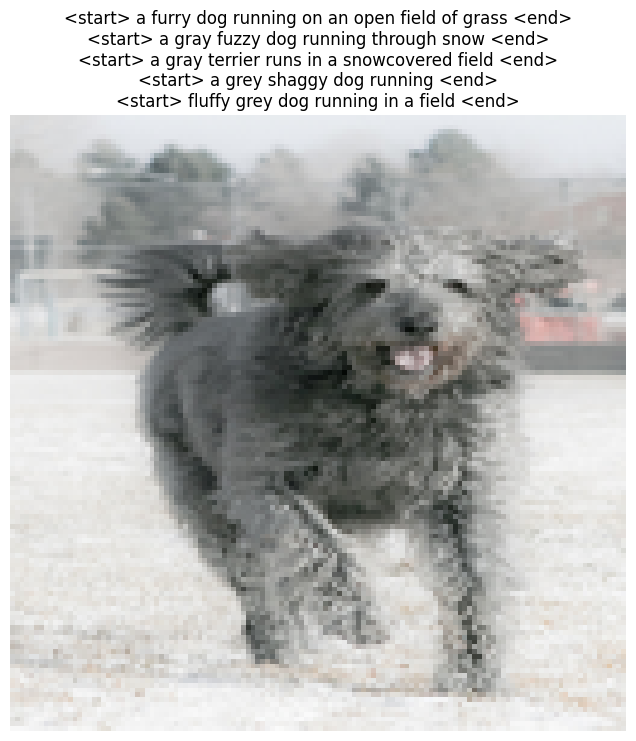

In [28]:
# Sample a minibatch and show the reshaped 112x112 images and captions
image_num = 1375

sample_images = data_dict['train_images'][image_num]
sample_captions = data_dict['train_captions'][image_num]
plt.imshow(process_images(sample_images, image_size=image_size).permute(1, 2, 0).to(torch.int32))
plt.axis('off')
caption_str = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
caption_str = "\n".join(caption_str)
plt.title(caption_str)
plt.show()

### RNN

In [29]:
# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=2048,
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=PAD_index,
          **to_float_cuda)

In [30]:
lr = 4e-3
epochs = 120
lr_decay = 0.97
batch_size=256
weight_decay = 5e-4
interval = 20


# Model and file paths
name = 'attention'
version = 3
checkpoint_path = f'{base_dir}/checkpoint/{name}_{version}_checkpoint.pth'
model_path = f'{base_dir}/models/{name}_{version}_checkpoint.pth'
history_path = f'{base_dir}/history/{name}_{version}.pth'


if os.path.exists(checkpoint_path):
    # Resume training from checkpoint
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model = rnn_model.to(device)
    model.load_state_dict(checkpoint['model_state'])

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    optimizer.load_state_dict(checkpoint['optimizer_state'])

    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** (epoch // interval))

    scheduler = CosineAnnealingLR(optimizer, T_max=120)

    if checkpoint['scheduler_state'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    start_epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Training will resume from epoch {start_epoch}.\n")

else:
    # Start new training
    print(f"Training new model: {name}\n")

    # Initialize model and optimizer
    model = rnn_model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = optim.SGD(model.fc.parameters(), min_lr)

    # Define scheduler
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** (epoch // interval))

    scheduler = CosineAnnealingLR(optimizer, T_max=120)

    # Initialize metrics and state
    start_epoch = 0
    best_val_acc = 0.0

# Train model
train_loss_history, val_loss_history = train_captioning_model(
    rnn_model, optimizer, data_dict, device='cuda', dtype=torch.float32,
    epochs=epochs, batch_size=batch_size, scheduler=scheduler, val_perc=1,
    image_size=image_size, verbose=True, checkpoint_path=checkpoint_path
)

# Save final model and history after training completes
torch.save(model.state_dict(), model_path)
print(f"Final model saved at: {model_path}")

with open(history_path, 'wb') as f:
    pickle.dump((train_loss_history, val_loss_history), f)
print(f"Training history saved at: {history_path}")





Training new model: attention

Epoch 1/120
  Batch 1/28, Loss = 104.2057
  Batch 11/28, Loss = 61.6668
  Batch 21/28, Loss = 51.8658
  Training Loss: 62.6813
  Validation Loss: 50.5055
Epoch 2/120
  Batch 1/28, Loss = 51.2506
  Batch 11/28, Loss = 49.9127
  Batch 21/28, Loss = 47.1033
  Training Loss: 48.1870
  Validation Loss: 44.9945
Epoch 3/120
  Batch 1/28, Loss = 44.8936
  Batch 11/28, Loss = 44.1241
  Batch 21/28, Loss = 44.2308
  Training Loss: 44.1419
  Validation Loss: 43.0180
Epoch 4/120
  Batch 1/28, Loss = 43.5014
  Batch 11/28, Loss = 41.6764
  Batch 21/28, Loss = 41.8387
  Training Loss: 42.0615
  Validation Loss: 41.3946
Epoch 5/120
  Batch 1/28, Loss = 41.3368
  Batch 11/28, Loss = 39.5797
  Batch 21/28, Loss = 39.4966
  Training Loss: 40.5055
  Validation Loss: 40.4408
Epoch 6/120
  Batch 1/28, Loss = 39.7573
  Batch 11/28, Loss = 41.5507
  Batch 21/28, Loss = 37.5882
  Training Loss: 39.0066
  Validation Loss: 39.3676
Epoch 7/120
  Batch 1/28, Loss = 39.4189
  Batch 1

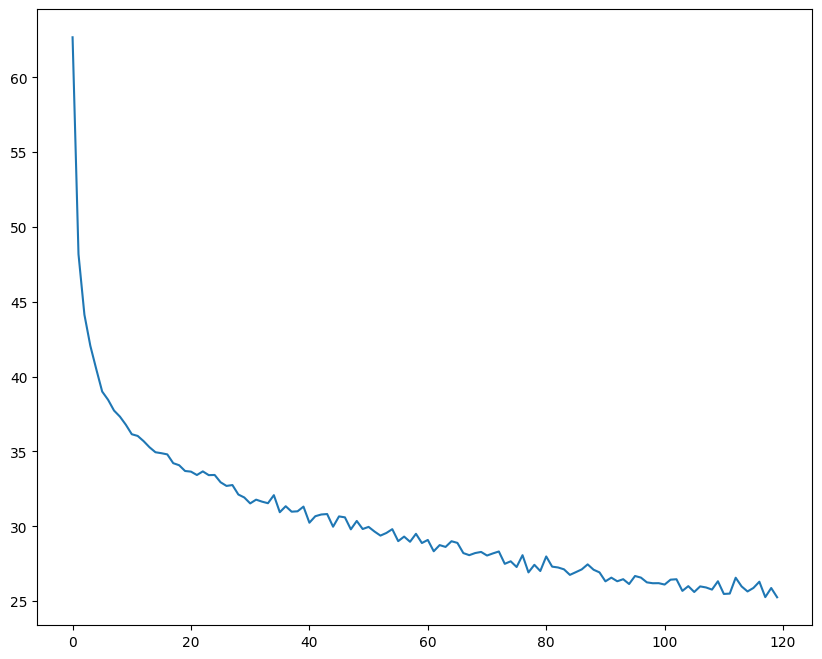

In [31]:
plt.plot(train_loss_history)

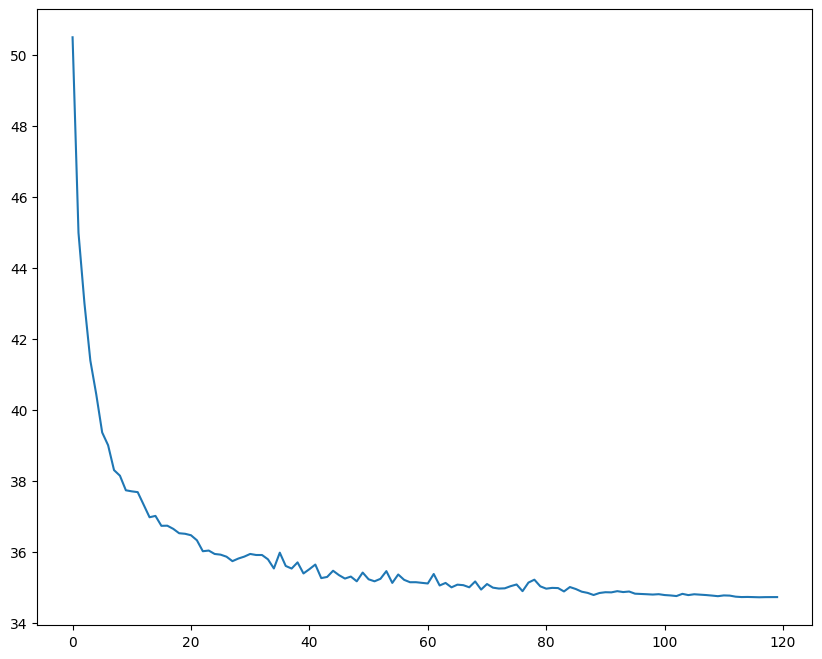

In [32]:
plt.plot(val_loss_history)